Notebook to test kernel herding with a GAN generator.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

In [2]:
import cadgan
import cadgan.kernel as kernel
import cadgan.glo as glo
import cadgan.main as main
import cadgan.plot as plot
import cadgan.embed as embed
import cadgan.util as util

import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.stats as stats
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

torch.set_default_tensor_type(torch.cuda.FloatTensor if use_cuda else torch.FloatTensor)


## Feature extractor for MNIST

In [6]:
classifier = torchvision.models.resnet18(pretrained=True)
classifier = classifier.eval()
classifier = classifier.to(device)
def extractor(imgs):
    """
    Feature extractor
    """
    self = classifier
    x=imgs
    
    up = nn.Upsample(size=224, mode='bilinear')
    x = up(x)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    #x = self.layer3(x)

    x = x.view(-1, 100352 )
    
    return x

## A generator for MNIST

In [8]:
import torch.nn as nn
class Generator(nn.Module):
    '''
        Generative Network
    '''
    def __init__(self, dataset='celebA'):
        
        super(Generator, self).__init__()
        
        z_size=100
        out_size=3
        ngf=128
        
        self.z_size = z_size
        self.ngf = ngf
        self.out_size = out_size

        self.main = nn.Sequential(
            # input size is z_size
            nn.ConvTranspose2d(self.z_size, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(inplace=True),
            # state size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),
            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),
            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),
            # state size: ngf x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: out_size x 64 x 64
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):

        output = self.main(input)

        return output

    def load(self,f):
        """
        Load a Generator from a file. To be used with save().
        """
        self.load_state_dict(torch.load((f)))
        return True

In [9]:
import cadgan.mnist.dcgan as mnist_dcgan

gan_fname = 'GAN_{}_G.pkl'.format(24)
gan_fpath = glo.prob_model_folder('lsun_dcgan', gan_fname)

# load a model
g = Generator()
g.load(gan_fpath)

latent_dim = 100
f_noise = lambda n: torch.randn(n, latent_dim).float()

#sample_z_ = Variable(torch.rand((batch_size, z_dim)).view(-1, z_dim, 1, 1), requires_grad=False).cuda()

## Optimize points jointly to minimize the moment matching loss

With a GAN generator. Optimize in the latent space.

In [ ]:
# def resize_gen_img(y):
#     # original Mnist images are 28x28 pixels
#     # The generator generates 32x32 images.
#     # Apply the following rescaling filter: 32x32 -> 28x28.
    
# #     y = y.clone() # need this clone because Normalize modifies in-place.
#     downscale_op = transforms.Compose([
#         # undo the range normalization
#         # When training the GAN, the following was used: transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         transforms.Normalize((0,), (1.0/0.5,)),
#         transforms.Normalize((-0.5,), (1,)),
#         transforms.ToPILImage(),
#         transforms.Resize((28, 28)),
#         transforms.ToTensor(),
#         # renormalize
#         transforms.Normalize((0.1307,), (0.3081,)),
#     ])
#     return downscale_op(y)

# def scale_up_real_img(x):
#     """
#     original Mnist images are 28x28 pixels
#     The generator generates 32x32 images.
#     Apply the following rescaling filter on real Mnist iamges: 28x28 -> 32x32
#     """
#     downscale_op = transforms.Compose([
#         # undo the range normalization
#         # When training the GAN, the following was used: transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         transforms.Normalize((0,), (1.0/0.3081,)),
#         transforms.Normalize((-0.1307,), (1,)),
#         transforms.ToPILImage(),
#         transforms.Resize((32, 32)),
#         transforms.ToTensor(),
#         # renormalize
#         transforms.Normalize((0.1307,), (0.3081,)),
#     ])
#     return downscale_op(y)

In [ ]:
# x = resize_gen_img(Y0[0].clone())
# plot.show_torch_imgs(x)

In [11]:
def sample_from_dir(dir_data, num_sample):
    """
    data: a dataset such that data[i][0] is a point, and data[i][1] is an integer label.
    label_counts: a list of tuples of two values (A, B), where A is a label, and B is the count.
    """
    list_selected = []
    #labels = np.array([data[i][1] for i in range(len(data))])
    for item in range(num_sample):
        list_selected.extend(homo_data)
    # stack all
    selected = torch.stack(list_selected)
    return selected

In [30]:
from PIL import Image
num_input = 1
test_img_dir = '../../pytorch-generative-model-collections/data/test_bedroom/'
imgs = []
for path in np.random.permutation(os.listdir(test_img_dir))[0:num_input]:
    img = Image.open(os.path.join(test_img_dir,path))

    img = img.resize((64,64))
    img = np.transpose(np.array(img),(2,0,1))
    imgs.append(img/255.0)

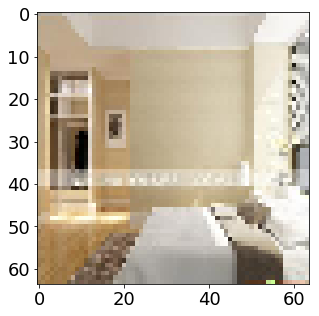

In [31]:
#img = np.transpose(np.array(img),(2,0,1)).reshape((1,3,64,64))
X = torch.tensor(imgs).float()
X = X.to(device)
n = X.shape[0]

# A vector of weights for all the points in X
weights = torch.ones(n)/float(n)
weights = weights.to(device)
plot.show_torch_imgs(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


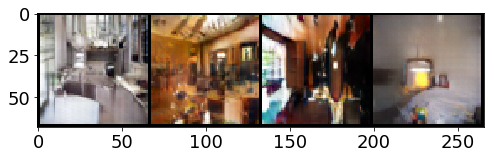

In [32]:
# initial points in the latent space
# n_sample = 2*2**3
n_sample = 4
# noise vectors
Z = f_noise(n_sample).view(-1, latent_dim, 1, 1)
Z = Z.to(device)

Z.requires_grad = True
Y0 = g(Z)

# plot the initial points in the image space
plot.show_torch_imgs(Y0.detach(), nrow=10)

In [ ]:
# avgpool = torch.nn.AvgPool2d(5, stride=1, padding=0)
# avgpool = avgpool.to(device)
# scaled = avgpool(Y0).detach()
# plot.show_torch_imgs(scaled)
# scaled.shape

In [33]:
# optimizer = torch.optim.SGD([Y], lr=5e-3)
# optimizer = torch.optim.RMSprop([Z], lr=1e-2)
optimizer = torch.optim.Adam([Z], lr=5e-1)
# kernel on the extracted features
# k = kernel.PTKGauss(sigma2=250.0)
k = kernel.PTKPoly(c=0, d=2)
# k = kernel.PTKIMQ()
# k = kernel.PTKLinear()

# kernel on the latent noise vectors
# k = kernel.PTKFuncCompose(kgauss, classifier)

# pre-extract the features of X. Fixed throughout the optimization

with torch.no_grad():
    FX = extractor(X)

/nethome/psangkloy3/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/nethome/psangkloy3/.local/lib/python3.5/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


/nethome/psangkloy3/.local/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/nethome/psangkloy3/.local/lib/python3.5/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


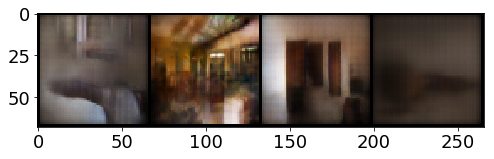

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


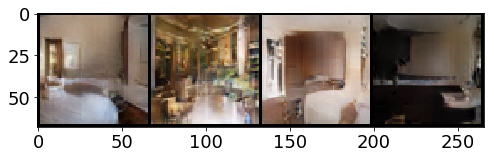

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


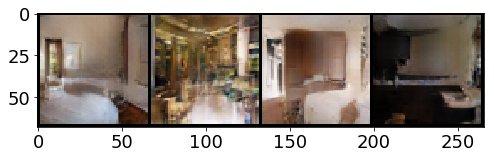

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


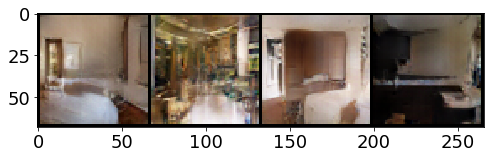

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


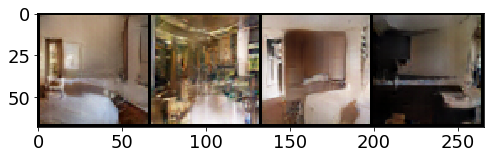

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


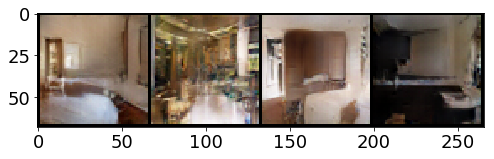

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


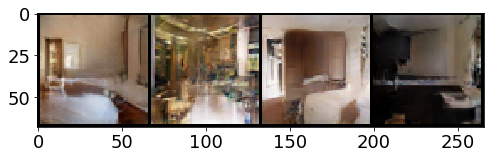

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


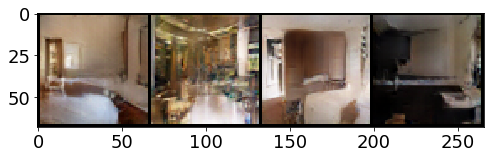

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


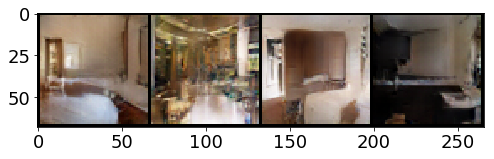

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


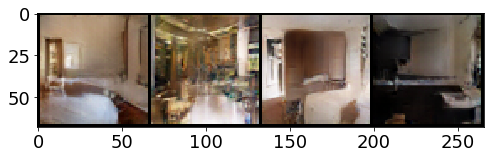

In [34]:
# optimization
n_iter = 5000
losses = []
sample_interval = 500
# avgpool = torch.nn.AvgPool2d(5, stride=1, padding=0)

mean_KFX = torch.mean(k.eval(FX, FX))
for t in range(n_iter):
    # need to resize since Mnist uses 28x28. The generator generates 32x32
    gens = g(Z)
#     resized = torch.stack([resize_gen_img(I) for I in gens], 0)
#     resized = avgpool(gens)
#     plot.show_torch_imgs(resized)
    F_gz = extractor(gens)
    KF_gz = k.eval(F_gz, F_gz)
#     print(KF_gz)
    
    # encourage the latent noise vectors to concentrate around 0
#     Z_reg = 1e+2*torch.mean(torch.sum(Z**2, 1))
    Z_reg = -torch.mean(torch.log(4.0**2-Z**2))
    loss = torch.mean(KF_gz)  - 2.0*torch.mean(k.eval(F_gz, FX).mv(weights)) + mean_KFX  + Z_reg
    losses.append(loss.item())
    
    optimizer.zero_grad()
    
    # compute the gradients
    loss.backward(retain_graph=True)
    # updates
    optimizer.step()
    
    #--------- plots the generated images ----
    if t%sample_interval==0:
        with torch.no_grad():
            gen = g(Z.detach().clone())
#             gen = Z.detach().clone()
#             gen = Z.grad.detach().clone()
            plot.show_torch_imgs(gen)
            plt.show()
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'Output')

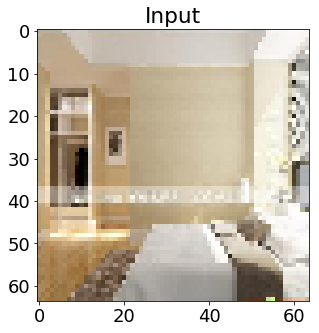

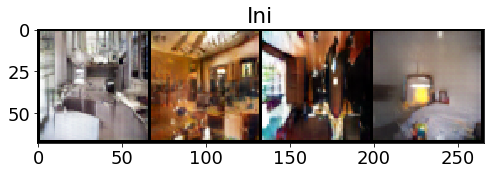

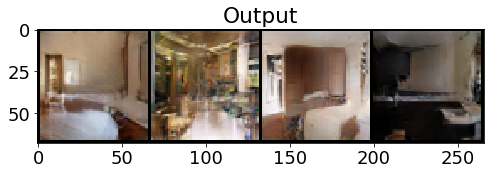

In [36]:
# input points
plot.show_torch_imgs(X)
plt.title('Input')
plot.show_torch_imgs(Y0.detach(), nrow=10)
plt.title('Ini')
plot.show_torch_imgs(gen)
plt.title('Output')

In [ ]:
plt.plot(losses)
plt.xlabel('Optimization iteration')
plt.ylabel('Herding loss')

In [ ]:
plt.imshow(Z.cpu().detach().numpy())
plt.colorbar()